# SVI

In [1]:
import numpy as np
import pandas as pd
import numba as nb
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use("dark_background")
pd.set_option('display.max_columns', 1000)
pd.set_option("display.precision", 2)
%matplotlib inline

import numpy as np
import pandas as pd
import numba as nb
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use("dark_background")
pd.set_option('display.max_columns', 1000)
pd.set_option("display.precision", 2)
%matplotlib inline
from pyquant.common import *
from pyquant.vol_surface import *
from pyquant.svi import *

In [2]:
from importlib import reload
import pyquant.svi
reload(pyquant.svi)
from pyquant.svi import *

In [3]:
bs_calc = BSCalc()
forward = Forward(Spot(100.), ForwardYield(0.01), TimeToMaturity(0.8))
strikes = np.array([1300., 1400, 1500, 1600, 1700, 1800., 1900, 2000, 2100, 2200])
tau = 0.01
F = 1723.75
forward = Forward(Spot(F), ForwardYield(0.01), TimeToMaturity(tau))
pvs = np.array([ 1.72375, 1.72375, 3.4475, 6.895, 26.718125, 11.204375,
                4.309375, 1.72375, 0.861875, 0.861875])
implied_vols = bs_calc.implied_vols(
    forward, 
    Strikes(strikes),
    Premiums(pvs)
).data

vol_smile_chain = VolSmileChainSpace(
    forward,
    Strikes(strikes),
    ImpliedVols(implied_vols)
)
weights = CalibrationWeights(np.ones_like(vol_smile_chain.Ks))
svi_calc = SVICalc()


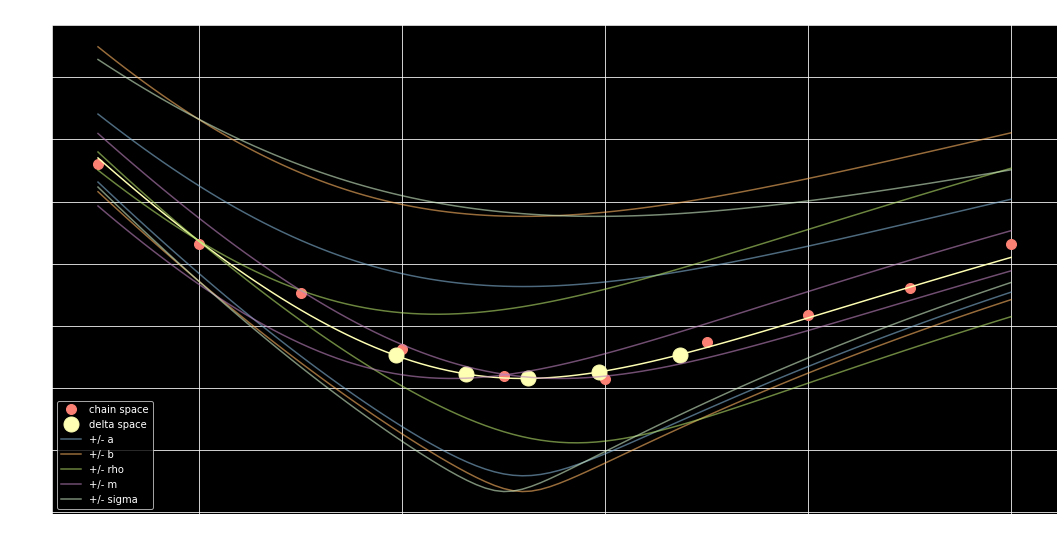

In [4]:
calibrated_params, error = svi_calc.calibrate(vol_smile_chain, weights)
calibrated_params.array()
test_strikes = Strikes(np.linspace(strikes[0], strikes[-1], 100))
test_iv = svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params)
delta_space_chain = svi_calc.delta_space(forward, calibrated_params).to_chain_space()
plt.figure(figsize=(18, 9))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20,  label='chain space')


plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.plot(delta_space_chain.Ks, 100*delta_space_chain.sigmas, '.C1', markersize=30, label='delta space')

plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_a(1.05)).data,
         'C4', label='+/- a', alpha=0.6)
plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_a(0.9)).data,
         'C4', alpha=0.6)

plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_b(1.2)).data,
         'C5', label='+/- b', alpha=0.6)
plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_b(0.95)).data,
         'C5', alpha=0.6)


plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_rho(1.1)).data,
         'C6', label='+/- rho', alpha=0.6)
plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_rho(0.8)).data,
         'C6', alpha=0.6)

plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_m(1.2)).data,
         'C7', label='+/- m', alpha=0.6)
plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_m(0.9)).data,
         'C7', alpha=0.6)

plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_sigma(1.2)).data,
         'C8', label='+/- sigma', alpha=0.6)
plt.plot(test_strikes.data, 
         100*svi_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_sigma(0.95)).data,
         'C8', alpha=0.6)


plt.title('SVI Calibration', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.legend(fontsize=10)
plt.show()

#### SVI greeks

Letting $PV = PV_B(\sigma_B)$ to be the present value of a call option (premium), with $PV_B$ denoting the Black-Scholes formula and $\sigma_B$ SABR implied vol. 
The forward value is:
$$
FV =\frac{PV}{D}
$$
where $D$ is our numeraire (or discounting), so that the spot is $S = D \cdot f$

The SABR greeks are given below in terms of Black-Scholes-Merton greeks:

* Sticky Delta (for the call):
$$\Delta_C =  \frac{\partial PV}{\partial S} =  \frac{1}{D}\frac{\partial PV}{\partial f} =  ... $$


For the put one can use the put-call parity:
$$\Delta_{P} = \Delta_{C} - 1$$

#### Delta space
Mapping from delta space:
$$
g(K) = \Delta_{BSM} - \delta \equiv 0 
$$
with implied volatility constrained by SVI is achieved computing the smile sensitivity to the strike:
$$
g'(K) = ...
$$

##### Example 1: ATM Straddle

In [5]:
atm_straddle = SingleMaturityVanillas(
            OptionTypes(np.array([False, True])), 
            Strikes(np.array([delta_space_chain.Ks[2], delta_space_chain.Ks[2]])), 
            Notionals(np.array([1000.,1000.])), 
            vol_smile_chain.time_to_maturity()
        )
atm_straddle.Ks

array([1723.92238362, 1723.92238362])

In [6]:
def svi_risk(portfolio, vol_smile_chain, calibrated_params):
    bs_calc = BSCalc()
    svi_calc = SVICalc()
    forward = vol_smile_chain.forward()
    
    ivs = svi_calc.implied_vols(forward, portfolio.strikes(), calibrated_params)

    df = pd.DataFrame({
        'present_value': svi_calc.premiums(forward, portfolio, calibrated_params).data,
        'notional': portfolio.Ns,
        'call': portfolio.is_call,
        'strike': portfolio.Ks,
        'implied_vol': ivs.data,
        
#         'delta': bs_calc.deltas(forward, portfolio, ivs).data,
#         'sticky_delta': svi_calc.sticky_deltas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
#         'strike_delta': svi_calc.sticky_deltas(forward, portfolio, calibrated_params, StickyStrike(True)).data,

        'vega': bs_calc.vegas(forward, portfolio, ivs).data,
#         'blip_vega': svi_calc.blip_vegas(forward, portfolio, calibrated_params).data,
#         'sticky_vega': svi_calc.sticky_vegas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
#         'strike_vega': svi_calc.sticky_vegas(forward, portfolio, calibrated_params, StickyStrike(True)).data,

#         'blip_rega': svi_calc.blip_regas(forward, portfolio, calibrated_params).data,
#         'rho_rega': svi_calc.regas_rho(forward, portfolio, calibrated_params).data,
        
#         'blip_sega': svi_calc.blip_segas(forward, portfolio, calibrated_params).data,        
#         'volvol_sega': svi_calc.segas_volvol(forward, portfolio, calibrated_params).data,

        'gamma': bs_calc.gammas(forward, portfolio, ivs).data,
#         'sticky_gamma': svi_calc.sticky_gammas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
#         'strike_gamma': svi_calc.sticky_gammas(forward, portfolio, calibrated_params, StickyStrike(True)).data,
        
        
        'volga': bs_calc.volgas(forward, portfolio, ivs).data,
#         'sticky_volga': svi_calc.sticky_volgas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
#         'strike_volga': svi_calc.sticky_volgas(forward, portfolio, calibrated_params, StickyStrike(True)).data,
        
        'vanna': bs_calc.vannas(forward, portfolio, ivs).data,
#         'sticky_vanna': svi_calc.sticky_vannas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
#         'strike_vanna': svi_calc.sticky_vannas(forward, portfolio, calibrated_params, StickyStrike(True)).data
    })
    return df, df.drop(columns=['notional','call','strike', 'implied_vol']).sum()
    
leg_risk, total_risk = svi_risk(atm_straddle, vol_smile_chain, calibrated_params)

In [7]:
leg_risk

,present_value,notional,call,strike,implied_vol,vega,gamma,volga,vanna
0,36950.14,1000.0,False,1723.92,0.54,4.31,4.31,-92.35,-1.99
1,36950.14,1000.0,True,1723.92,0.54,4.31,4.31,-92.35,-1.99


In [8]:
total_risk

present_value    73900.29
vega                 8.61
gamma                8.61
volga             -184.71
vanna               -3.99
dtype: float64

##### Example 2: Risk Reversal

In [9]:
risk_reversal_10 = SingleMaturityVanillas(
            OptionTypes(np.array([False, True])), 
            Strikes(np.array([delta_space_chain.Ks[0], delta_space_chain.Ks[-1]])), 
            Notionals(np.array([-1000.,1000.])), 
            vol_smile_chain.time_to_maturity()
        )
risk_reversal_10.Ks

array([1593.33960864, 1873.45179446])

In [10]:
leg_risk_rr, total_risk_rr = svi_risk(risk_reversal_10, vol_smile_chain, calibrated_params)

In [11]:
leg_risk_rr

,present_value,notional,call,strike,implied_vol,vega,gamma,volga,vanna
0,-5280.24,-1000.0,False,1593.34,0.63,-1.62,-1.62,-74970.00,-33.94
1,5036.27,1000.0,True,1873.45,0.63,1.61,1.61,82316.68,-37.26


In [12]:
total_risk_rr

present_value   -2.44e+02
vega            -8.34e-03
gamma           -8.34e-03
volga            7.35e+03
vanna           -7.12e+01
dtype: float64

##### Example 3: Vega Neutral Butterfly

In [13]:
butterfly_10 = SingleMaturityVanillas(
            OptionTypes(np.array([False, False, True, True])), 
            Strikes(np.array([delta_space_chain.Ks[0], delta_space_chain.Ks[2], delta_space_chain.Ks[2], delta_space_chain.Ks[-1]])), 
            Notionals(np.array([1000.,-1000., -1000., 1000.])), 
            vol_smile_chain.time_to_maturity()
        )
butterfly_10.Ks

array([1593.33960864, 1723.92238362, 1723.92238362, 1873.45179446])

In [14]:
ivs = np.array([delta_space_chain.sigmas[0], delta_space_chain.sigmas[2], delta_space_chain.sigmas[2], delta_space_chain.sigmas[-1]])
vegas = bs_calc.vegas(forward, butterfly_10, ImpliedVols(ivs))
vegas.data

array([ 1.61571068, -4.30523646, -4.30523646,  1.60736847])

In [15]:
ivs = np.array([delta_space_chain.sigmas[0], delta_space_chain.sigmas[2], delta_space_chain.sigmas[2], delta_space_chain.sigmas[-1]])
vegas = bs_calc.vegas(forward, butterfly_10, ImpliedVols(ivs))
butterfly_10.Ns[1:-1] = (vegas.data[0] + vegas.data[-1])  / (-2*vegas.data[1]) * butterfly_10.Ns[1:-1]
butterfly_10.Ns

array([1000.        , -374.32080467, -374.32080467, 1000.        ])

In [16]:
leg_risk_bb, total_risk_bb = svi_risk(butterfly_10, vol_smile_chain, calibrated_params)

In [17]:
leg_risk_bb

,present_value,notional,call,strike,implied_vol,vega,gamma,volga,vanna
0,5280.24,1000.00,False,1593.34,0.63,1.62,1.62,74970.00,33.94
1,-13831.21,-374.32,False,1723.92,0.54,-1.61,-1.61,34.57,0.75
2,-13831.21,-374.32,True,1723.92,0.54,-1.61,-1.61,34.57,0.75
3,5036.27,1000.00,True,1873.45,0.63,1.61,1.61,82316.68,-37.26


In [18]:
total_risk_bb.round(2)

present_value    -17345.91
vega                  0.00
gamma                 0.00
volga            157355.82
vanna                -1.83
dtype: float64